In [1]:
import torch
from torchvision import transforms
from models import PerceptAnonHA1

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

/home/kpatwari/miniconda3/envs/anon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
checkpoint_path = 'results/ckpts/HA1/resnet50/all/mean.pth.tar'
num_outputs = 1
device = torch.device('cuda:0')
img_path = 'data/perceptanon_data/lfw/global_blurpix/Thomas_Rupprath_0001.jpg'
is_classification = True

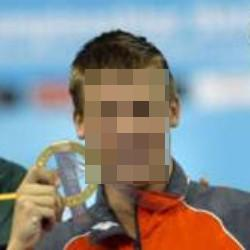

In [13]:
image = Image.open(img_path).convert('RGB')
image

In [5]:
model = PerceptAnonHA1(num_outputs=num_outputs, is_classification=is_classification).get_model('resnet50')
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
print('loaded HA1 RN50')

loaded HA1 RN50


In [14]:
# Test transforms applied to input
test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# load & transform image
input_tensor = test_transforms(image)
input_tensor = input_tensor.unsqueeze(0)

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
targets = None
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

import numpy as np
# image_array = np.array(image)
# image_array_float32 = image_array.astype(np.float32) / 255.0

def center_crop(img, new_width, new_height):
    width, height = img.shape[1], img.shape[0]
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2
    return img[starty:starty+new_height, startx:startx+new_width]

# Resize the image (using PIL in this example)
image_resized = image.resize((256, 256))

# Convert to NumPy array and change to float32
image_array = np.array(image_resized).astype(np.float32)

# Center crop to 224x224
image_cropped = center_crop(image_array, 224, 224)

# Normalize
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])
# image_normalized = (image_cropped / 255.0 - mean) / std
image_normalized = image_cropped.astype(np.float32) / 255.0
gradcam_image = show_cam_on_image(image_normalized, grayscale_cam, use_rgb=True)

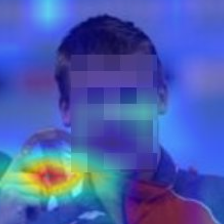

In [15]:
output_image = Image.fromarray(gradcam_image)
output_image